In [1]:
import networkx as nx
import numpy as np
import csv
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [3]:
def plot_CCDF(kis):
    # input : a list of degrees, e.g., from a networkx graph G
    # output: a plot of the CCDF of the degree distribution Pr(K>=k) for k>=1
    
    kmax = max(kis)

    # histogram and plot
    counts, bins = np.histogram(kis, bins=[i for i in range(kmax+2)], density=True)
    cumcounts = np.cumsum(counts)
    cumcounts = np.insert(cumcounts,0,0)
    plt.loglog(bins[1:-1], 1-cumcounts[1:-1], 'rs', alpha=0.5)
    plt.xlabel('Degree, k')
    plt.ylabel('Pr(K>=k)')
    plt.show()
    return

In [4]:
def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####

    edges = list(G.edges())
    for e in edges:
        r = z[int(e[0])]
        s = z[int(e[1])]
        wrs[r,s] = wrs[r,s] + 1
        wrs[s,r] = wrs[s,r] + 1
    kpr = np.sum(wrs,axis=1)

        
    ##### do not modify below here #####

    return wrs,kpr

In [5]:
def random_z(n,c):
    # input  : number of nodes n, and number of groups c
    # output : returns a random partition in a dictionary z, where z_i = Uniform(0,c-1)

    import random as rnd
    rnd.seed()
    
    z = dict()

    ##### do not modify above here #####

    
    for i in range(n):
        z[i] = int(rnd.randint(0,c-1))
    

    ##### do not modify below here #####

    return z

In [6]:
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION


In [7]:
def plotLL(LL,pc,n):
    # DO NOT MODIFY THIS FUNCTION
    # This function makes a nice plot of the log-likelihood trajectory
    #
    # input  : LL is list of log-likelihood values of length (n+1)*(pc+1)
    #        : n, number of nodes
    #        : pc, number of phases in LL
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    tc  = len(LL)               # number of partitions considered in the LL trajectory

    fig = plt.figure()
    ax1 = fig.add_subplot(111) # put multiple 
    
    plt.plot(range(tc), LL, 'b.-', alpha=0.5)  # plot the log-likelihood trajectory
    for i in range(pc):                        # add vertical bars to demarcate phases, add black squares for phase-maxima
        plt.plot([(i)*(n+1),(i)*(n+1)],[min(LL),max(LL)], 'k--', alpha=0.5) # vertical bar
        LLp = LL[(i)*(n+1):(i+1)*(n+1)]
        b = LLp.index(max(LLp))
        plt.plot([(i)*(n+1)+b],[max(LLp)], 'ks', alpha=0.5)

    plt.ylabel('log-likelihood, DC-SBM')
    plt.xlabel('number of partitions considered')
    plt.show()

In [8]:
def fit_DCSBM(G,c,T):
    # Runs the full locally greedy heuristic, with c groups
    # Returns the best partition found, its LogL, and the list of LogL values for all partitions considered
    # input  : G, a graph
    #        : c, the number of groups
    #        : T, the number maximum number of phases allowed
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of all LogL values considered
    #        : pc, the number of phases in LL

    import copy # for copy.deepcopy()
    
    # 1.0 locally greedy heuristic setup
    n  = G.order() # n, number of nodes
    LL   = []      # log-likelihoods over the entire algorithm (concat via .extend)
    halt = 0       # convergence flag

    # 2.0 generate initial partition, calculate wrs,kpr, and store the loglikelihood in Lt
    zt      = random_z(n,c)       # z0, initial partition
    wrs,kpr = tabulate_wk(G,zt,c) # wrs, kpr, initial DC-SBM parameters
    Lt      = dcsbm_LogL(wrs,kpr) # store initial DC-SBM log-likelihood

    # 3.0 the main loop
    pc = 0  # counter for number of phases completed
    while not halt:
        # 3.1 visualization of this phase's initial partition
        print(f'phase[{pc}] z[0], logL = {Lt}')
        drawGz(G,zt)

        ##### do not modify above here #####

        
        zstar, Lstar, phaseLL, halt = run_OnePhase(G,zt,c)
        LL.extend(phaseLL)
        zt = copy.deepcopy(zstar)
        Lt = Lstar
        
        if pc>=T:
            halt = 1
        else: 
            pc = pc + 1

        ##### do not modify below here #####
    
    print(f' --> WE HAVE CONVERGENCE <-- ') # a friendly alert
    return zstar,Lstar,LL,pc

In [9]:
def fit_DCSBM_reps(G,c,T,reps):
    import copy
    
    Lbest = -np.inf
    for i in range(reps):
        zstar,Lstar,LL,pc = fit_DCSBM(G,c,T)
        if Lstar > Lbest:
            zbest = copy.deepcopy(zstar)
            Lbest = Lstar
            LLbest = LL
            pcbest = pc
    return zbest,Lbest,LLbest,pcbest

In [10]:
def makeAMove(G,z,c,f):
    # For each non 'frozen' node in the current partition, this function tries all (c-1) possible group moves for it
    # It returns the combination of [node i and new group r] that produces the best log-likelihood over the non-frozen set
    # input  : G, a graph
    #        : z, a partition of G's nodes
    #        : c, the number of groups
    #        : f, a binary labeling of frozen nodes
    # output : bestL, the best log-likelihood found
    #        : bestMove, [i,r] the node i and new group r to achieve bestL
    
    bestL = -np.inf            # the best log-likelihood over all considered moves
    for i in G.nodes():        # loop over all nodes i
        if f[i] == 0:          # if i is not frozen
            s = int(z[i])      #  get current label of i
            for r in range(c): #  then loop over all groups r
                #print(f'v[{i}] s = {s}, r={r}, {r!=s}') # for debugging
                
                ##### do not modify above here #####
                if r != s:
                    z[i] = r
                    wrs,kpr = tabulate_wk(G,z,c)
                    thisL = dcsbm_LogL(wrs,kpr)
                    
                    if thisL > bestL:
                        bestL = thisL
                        bestMove = [i,r]
                        
            z[i] = s
                
               
                
                
                ##### do not modify below here #####    
                
    return bestL,bestMove

In [11]:
def run_OnePhase(G,z0,c):
    # Runs one phase, initialized from partition z0
    # Returns the best partition found in the phase and the list of LogL values for all the phase's partitions
    # input  : G, a graph
    #        : z0, initial partition of G's nodes
    #        : c, the number of groups
    # output : zstar, the best partition of the phase
    #        : Lstar, the LogL of zstar
    #        : LL, the inorder list of LogL values for the n+1 partitions of this phase
    #        : halt, 1 if zstar=z0 (no better partition found)

    import copy      # for copy.deepcopy() function
    n    = G.order() # n, number of nodes
    LL   = []        # stores log-likelihoods over the entire algorithm (via .append)
    halt = 0         # flag: =0 if Lstar > L0 at the end of the phase; =1 if Lstar <= L0

    # initialize the phase
    wrs,kpr = tabulate_wk(G,z0,c)      # wrs, kpr, initial DC-SBM parameters
    L0      = dcsbm_LogL(wrs,kpr)      # store initial DC-SBM log-likelihood
    LL.append(L0)                      # track log-likelihood

    f     = dict.fromkeys(range(n), 0) # initially, all nodes unfrozen (tricky python)
    t     = 0                          # number of frozen nodes in this phase
    Lstar = L0                         # initially, z0 has the best LogL
    zstar = copy.deepcopy(z0)          # and z0 is the best partition
    tstar = t                          # tstar = 0

    # loop over all the nodes in G, making greedy move for each
    zt = copy.deepcopy(z0)             # start the loop at z0
    for j in range(n):
        #print(f'step {j}') # for debugging

        ##### do not modify above here #####

        
        ### YOUR CODE
        
        choiceL,choiceMove = makeAMove(G,zt,c,f)
        i = choiceMove[0]
        r = choiceMove[1]
        zt[i] = r
        f[i] = 1
        t = t + 1
        Lt = choiceL
        LL.append(choiceL)
        
        if Lt > Lstar:
            Lstar = Lt
            zstar = copy.deepcopy(zt)
            tstar = t
            
        
    if tstar == 0:
        halt = 1

        ##### do not modify below here #####

    return zstar,Lstar,LL,halt

reading the network file : ComNet_all.csv

number of nodes, n  = 1474
number of edges, m  = 43734
mean degree,    <k> = 59.34
clustering coefficient, C     =  0.19
mean geodesic distance, <ell> =  2.08


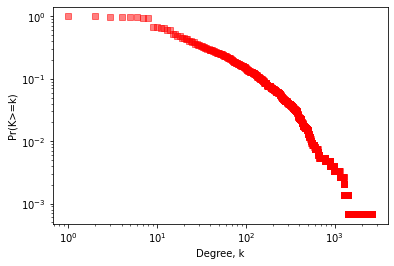

In [13]:
fname1 = 'ComNet_all.csv'

# read in the network file (an edge list)
print(f'reading the network file : {fname1}\n')
G = nx.DiGraph()  # import as a simple graph, index nodes by integers (not strings)

with open('ComNet_all.csv', newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            if G.has_edge(row[0],row[1]) == False or G.has_edge(row[1],row[0]) == False:
                G.add_edge(row[0],row[1])
    

#YOUR CODE HERE
n = nx.number_of_nodes(G)
m = nx.number_of_edges(G)
kmean = 2*m/n
C = nx.transitivity(G)
ellmean = nx.average_shortest_path_length(G)
degrees = nx.degree(G)
kis = [k for _,k in degrees]

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

plot_CCDF(kis)

# plt.figure(1, figsize=(10,10))
# plt.title("HVR_1 Ridiculogram")
# pos = nx.spring_layout(G)
# nx.draw(G, pos)
# edge_labels = nx.get_edge_attributes(G, 'label')
# nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
# nx.draw_networkx_labels(G, pos, font_size=10)
# plt.show()

phase[0] z[0], logL = -467336.2864100772


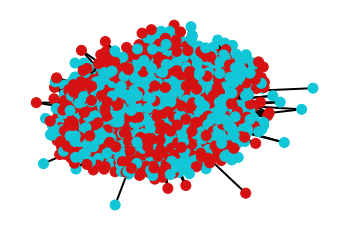

KeyboardInterrupt: 

In [23]:
Go = nx.convert_node_labels_to_integers(G) # map node names to integers (0:n-1) [because indexing]

c    = 2       # c, number of groups
T    = 30      # maximum number of phases; HALT if pc >= T
reps = 10      # number of repetitions of fit_DCSBM()

##### do not modify above here #####

# YOUR CODE HERE

zbest,Lbest,LLbest,pcbest = fit_DCSBM_reps(Go,c,T,reps)

print(f'best output: {pc} phase and z0 logL = {Lbest}')
drawGz(Go, zbest)
plotLL(LLbest,pcbest,Go.order())
wrs,kpr = tabulate_wk(Go,zbest,c)
print(f'kappa_r = ')
print(kpr)
print(f'w_rs = ')
print(wrs)

In [ ]:
#recreate results from net_all_ages.csv file
z = {} #holds the data we are trying to recereate
node_vals = list(G.nodes().keys())
node_data = {}
between = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
for i in range(len(node_vals)):
    z[i] = (node_vals[i], nx.clustering(G, node_vals[i]), nx.eccentricity(G, node_vals[i]), (G.degree[node_vals[i]]/2) - 1, between[node_vals[i]], closeness[node_vals[i]],(G.degree[node_vals[i]]/2) - 1, list(G.neighbors(node_vals[i])) != [])


In [ ]:
#dict: Columns -> NodeName, ClusterinCoeff, Eccentricty, NumberOfEdges, betweeness centrality, closeness centrality, degree, is Single Node
print(z)